### Student Name: Tan Thien Nguyen - C00278719
### 4. Modeling  <a class="anchor" id="4-bullet"></a>
4.1. [Data Preprocessing](#4.1-bullet)

4.2. [Feature Vectorizing - Bag of Words](#4.2-bullet)

4.3. [Select Modeling technique](#4.3-bullet)
  
4.4. [Generate Test Design](#4.4-bullet)

4.5. [Build Model](#4.5-bullet)

4.6. [Assess Model](#4.6-bullet)

### 5. Evaluation  <a class="anchor" id="5-bullet"></a>
5.1. [Evaluate the results](#5.1-bullet)

5.2. [Review Process](#5.2-bullet)

5.3. [Determine next steps](#5.3-bullet)

---------------------------------------------------------

#### Import library and Create transform methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

## 4. Modeling  <a class="anchor" id="4-bullet"></a>
### 4.1. Data Preprocessing <a class="anchor" id="4.1-bullet"></a>
Basically, in the CRISP-DM model design, This part will be implemented in phase 03. Data Preparation. However, to make it easy to follow up and do necessary tests, I move the part Data Preprocessing to phase 04. Modeling in this notebook. This part will do the followings:

- **Feature Selection**

Only necessary features used in modeling will be selected. In particular, cleanText feature and target variable, ratingClass are selected. We will go into detail about Target variable descriptive statistics and encode it.

- **Split train set and test set**

We have 450863 observations in the dataset.  We do this step first so that we can ensure the test set is as unbiased as it can be and reflects a true evaluation of the model.
If we balance data before splitting, this might introduce bias in the test set where a few data points in the test set are synthetically generated and well-known from the training set.


### Feature Selection

In [2]:
# Load data
df_model_raw = pd.read_json('Output/reviewPreprocessing.json', lines=True)

# Select feature
df_model = df_model_raw[['cleanText','ratingClass']].copy()

In [3]:
# Verify data types and non-null values
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450863 entries, 0 to 450862
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   cleanText    450863 non-null  object
 1   ratingClass  450863 non-null  object
dtypes: object(2)
memory usage: 6.9+ MB


In [4]:
# View data sample
df_model.head(5)

,cleanText,ratingClass
0,materials arrive early excellent condition how...,Good
1,really enjoy book worksheets make review goals...,Good
2,take class dont waste money call book 14000 bo...,Bad
3,book miss page important page couldnt answer t...,Bad
4,use learnsmart officially say amaze study tool...,Good


#### Target Variable Decriptive Statistics

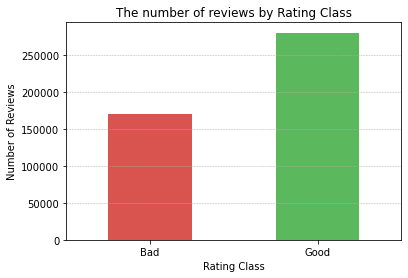

In [5]:
colors_list = ['#d9534f', '#5cb85c']
df_model['ratingClass'].value_counts().sort_index().plot(kind='bar', color=colors_list)
plt.title('The number of reviews by Rating Class')
plt.xlabel('Rating Class')
plt.xticks(rotation=0)
plt.ylabel('Number of Reviews')
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
plt.show()

In [6]:
# Percentage of rating class 
round(df_model['ratingClass'].value_counts() * 100 / df_model['ratingClass'].count(),0)

Good    62.0
Bad     38.0
Name: ratingClass, dtype: float64

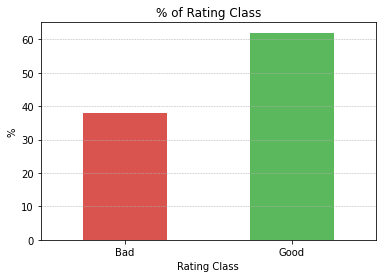

The dataset is imbalanced but not so serious


In [7]:
colors_list = ['#d9534f', '#5cb85c']
t = round(df_model['ratingClass'].value_counts() * 100 / df_model['ratingClass'].count(),0)
t.sort_index().plot(kind='bar', color=colors_list)
plt.title('% of Rating Class')
plt.xlabel('Rating Class')
plt.xticks(rotation=0)
plt.ylabel('%')
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
plt.show()
print("The dataset is imbalanced but not so serious")

#### Encode Target Variable

In [8]:
model = df_model.copy()
model['ratingClass'] = model['ratingClass'].apply(lambda x: 0 if x == 'Bad' else 1)

####  Separate Target Variable and Feature

In [9]:
X = model['cleanText']
y = model['ratingClass']

### Split the training set and test set
In this part, we will use the train_test_split transformer in the scikit-learn library to split the training set and test set. 

- Total of observations: 458863. 
- ***test_size=0.25*** : We will split the training set and test set with the ratio 75:25 
- ***stratify=y*** : to make stratified sampling. 
The reason for this is to make sure that the test set is representative of various categories in the whole dataset and to preserve the same proportions of examples in each category observed in the original dataset. 

- ***random_state=42*** : to reproduce the same training set and test set every time we do the split.


In [10]:
# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [11]:
# Summary of training set and test set
print ('Training Set\t:{}\nTest Set\t:{}'.format(X_train.shape, X_test.shape))

Training Set	:(338147,)
Test Set	:(112716,)


In [12]:
# ratingclass in the training set
y_train.value_counts()

1    210484
0    127663
Name: ratingClass, dtype: int64

In [13]:
# Percentage of rating class 
round(y_train.value_counts() * 100 / y_train.count(),0)

1    62.0
0    38.0
Name: ratingClass, dtype: float64

In [14]:
# ratingclass in the test set
y_test.value_counts()

1    70161
0    42555
Name: ratingClass, dtype: int64

In [15]:
# Percentage of rating class 
round(y_test.value_counts() * 100 / y_test.count(),0)

1    62.0
0    38.0
Name: ratingClass, dtype: float64

#### We completed splitting the training set and the test set. Now, we can forget the test set until the evaluation phase and just focus on the training set.

### 4.2. Feature Vectorizing - Bags of Words (TF-IDF) <a class="anchor" id="4.2-bullet"></a>

Most algorithms require numerical features, so we need to transform the string representation of the text
into a numeric representation that we can apply our machine learning algorithms to. Therefore, we implement the vectorization process to turn a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting, and normalization) is called the ***Bag of Words or “Bag of n-grams”*** representation (Andrea and Sarah, 2017, Scikit-learn Developers, 2022).

The most popular vectorizer in scikit-learn is ***CountVectorizer***. CountVectorizer is a transformer in scikit-learn which implements bag-of-words representation. However, CountVectorizer only counts the number of times a word appears in a document. This will result in bias in favour of the most frequent words and lead to ignoring other meaningful words in the document (Andrea and Sarah, 2017, Medium, 2022). 

To overcome this, we use ***TfidfTransformer- Term Frequency Inverse Document Frequency (TF-IDF)***. TF-IDF is a measure of a word by comparing the number of times a word appears in a document with the number of documents the word appears in. ***Term Frequency (TF)*** enlists the number of times the words present in the entire dataset occur in the different sentences. And ***Inverse Document Frequency (IDF)*** aims to reflect the importance of a word in a document in a collection or corpus (Medium, 2022). In more detail, using TF-IDF to give high weight to any term that often appears in a particular document but not in many documents in the corpus. If a word often appears in a particular document but not in very many documents, it is likely to be very descriptive of the content of that document (Andrea and Sarah, 2017).

We can use ***TfidfTransformer***, which takes in the sparse matrix output produced by CountVectorizer and transforms it, and ***TfidfVectorizer***, which takes in the text data and does both the bag-of-words feature extraction and the tf–idf  transformation (Andrea and Sarah, 2017).

There is a note that CountVectorizer could do removing stopwords, lowercase, and remove punctuation which we did in 03. Data Preparation. So, the question is why we don't do that using CountVectorizer but using manual functions. The reasons are:
- Stopwords used in CountVectorizer is 318. It contains a lot of meaningful words. So, we used the stopwords list in NLK library 179.
- To generate the WordCloud, we should use lowercase to minimize the frequency of single words like 'house', 'House', ' HOUSE'
- CountVectorizer cannot remove all punctuation and html tags.


#### Apply TFIDF Vectorizer to the training set

In [16]:
# Apply Tfidf Vectorizer
tf_idf_vectorizer = TfidfVectorizer()
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)

In [17]:
# Check Vocabulary size
print("Vocabulary size: {}".format(len(tf_idf_vectorizer.vocabulary_)))

Vocabulary size: 319790


In [18]:
# Type and shape of vectorized text data 
print(type(X_train_tf_idf))
X_train_tf_idf.shape

<class 'scipy.sparse.csr.csr_matrix'>


(338147, 319790)

##### As we can see, vectorized text data is a scipy sparse 338147x319790 matrices. It is impossible to print out this matrices. So, we will try to print out some features with lowest and highest tf-idf

In [19]:
# find maximum value for each of the features over the dataset
max_value = X_train_tf_idf.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

# get feature names
feature_names = np.array(tf_idf_vectorizer.get_feature_names_out())

# Show the feature with lowest and highest tfidf
print("Features with lowest tfidf:\n{}".format(feature_names[sorted_by_tfidf[:20]]))

print("\nFeatures with highest tfidf: \n{}".format(feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['gupta243' 'ssaleslivepersonnethc77038303cmdfilefilechattemplates'
 'penelopecarpenterymailcom' '265458' 'updatedyour' '17913380'
 'twkdtgpqkjbgk62kmyyrg33rm' '09162014' '21621' '55621' '05621' '00121'
 '15621' '55121' '2904' '2906' '2907' '2912' '05121' '2917']

Features with highest tfidf: 
['difficultif' 'aokaok' 'satisfy' 'nicegreat' 'nicelove' 'jobrefund'
 'nicenice' 'appkindle' 'uselessuseless' 'jobvista' 'niceok' 'garmin'
 'crapjunk' 'crapcrap' 'crackedcracked' 'soso' 'nicetry' 'expirenorton'
 'junkbad' 'wantedcalc']


#### Transform the Test set

In [20]:
# Transform the test set
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

### 4.3. Select Modeling technique <a class="anchor" id="4.3-bullet"></a>

Choosing the right model is a tricky part. One of our data mining goals is to predict categorical customer ratings based on labeled reviews. Therefore, we select a classification algorithm, one of the supervised machine learning algorithms.

From the literature review (Andreas and Sarah, 2017, Aurelien, 2019, Medium, 2022):

**K-NN classifier** is easy to understand but does particularly badly with datasets with many features and not often used in practice. 

**Kernelized SVMs** don’t scale very well with the number of samples. Running an SVM on data with up to 10,000 samples might work well, but working with datasets of size 100,000 or more can become challenging in terms of runtime and memory usage.

**Decision trees** work well when we have features that are on completely different scales or a mix of binary and continuous features, but this algorithm tends to overfit and provide poor generalization performance.

**Random forests** don’t tend to perform well on very high dimensional, sparse data, such as text data. For this kind of data, linear models might be more appropriate.

**Naive Bayes classifiers** are a family of classifiers that are quite similar to the linear models discussed in the previous section. However, they tend to be even faster in training. The reason that naive Bayes models are so efficient is that they learn parameters by looking at each feature individually and collect simple per-class statistics from each feature. The price paid for this efficiency is that naive Bayes models often provide generalization performance that is slightly worse than that of linear classifiers like LogisticRegression and LinearSVC. For high-dimensional, sparse data like this, linear models like LogisticRegression and LinearSVC often work best.


I decided to select **Linear Support Vector Classification (LinearSVC)** to build the model for predicting rating class based on reviews. Besides, I also use the **LogisticRegression** model as a reference model for performance comparison.


#### Setting up Parameters for linear models

Building a model that is too complex will lead to overfitting. It means that our model is too close to the particularities of the training set, but it is not able to generalize well to new data, the test set. On the other hand, if our model is too simple, it may not be able to capture all variability of the data and lead to bad generalization on the training set or underfitting. The trade-off between overfitting and underfitting is expected to be resolved by figuring out a sweet pot that is controlled by parameters (Andreas and Sarah, 2017).

**C** is the trade-off parameter that determines the strength of the regularization. A high value of C means that the model tries to fit the training set as best as possible. With a low value of C, the model put more emphasis on finding a coefficient vector that is close to zero. C is usually has 6 value options (0.001, 0.01, 0.1, 1, 10, 100). In this project, we set C = 1 as default to evaluate the performance.

**class_weight = "balanced"** : so that the model can automatically assign the class weights inversely proportional to their respective frequencies. For example, in our dataset:

n samples = 338147

class 0 =  127663 

Weights for class 0: w0 =  338147/(2*127663) = 1.324

class 1 =  210484

Weights for class 1: w1 = 338147/(2*210484) = 0.803


In [21]:
# Logistic Regression model
logreg = LogisticRegression(C=1, max_iter=1000, class_weight = "balanced")

# Linear Support Vector Classification model
svc = LinearSVC(C=1, max_iter=1000, class_weight = "balanced")

### 4.4. Generate Test Design <a class="anchor" id="4.4-bullet"></a>

#### Select the Right Evaluation Metric
##### Confusion Matrix
Our machine learning problem is a binary classification problem. One of the most comprehensive ways to represent the result of evaluation for binary classification problems is using confusion matrices (Andreas and Sarah, 2017, Aurelien, 2019). 

Confusion matrix for binary classification is a 2x2 array where rows correspond to the true class (y_test), and the columns correspond to the predicted class (y_pred).

##### Accuracy, Precision, Recall, and F1-score
- Accuracy is the number of correct predictions divided by the number of all samples = (TN+TP) / (TN+TP+FN+FP)
- Precision measures how many of the samples are predicted as positive as actually positive = TP / (TP+FP). If Precision is high, FP has to be small. So, Precision is useful when we want to limit the number of false positives.
- Recall, on the other hand, = TP / (TP + FN),  measures how many of the positive samples are captured by the positive predictions. Recall is useful when we need to avoid FN 
- F-score is the harmonic mean of precision and recall, is used to provide the full picture = 2(Precision.Recall) / (Precision+Recall)


#### Classification Report
If we just use the Confusion Matrices or calculate Precision, Recall, and F1-score separately, we need to define which class is positive. However, there is an easier method to get all of these metrics in one shot by using a classification report.

***classification_report*** is a library in scikit-learn that allows us to have a comprehensive summary of precision, recall, and f1-score.

Since our dataset is imbalanced, Precision, Recall, and F1-score are better measuring than accuracy. And we will pay a bit more attention to the minority class, which is a bad rating class (class 0).


### 4.5. Build model <a class="anchor" id="4.5-bullet"></a>

#### Build a function to model and evaluate in one shot

In [22]:
def modeling_evaluation(model, X_train, X_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print("------ Confusion Matrix ------\n")
    print(confusion_matrix(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.show()
    print("\n")
    print("---- Classification report for Training Set -----\n")
    print(classification_report(y_train,y_pred_train))
    print("\n")
    print("---- Classification report for Test Set -----\n")
    print(classification_report(y_test,y_pred))

#### Fit Logistic Regression Model to the training set

In [23]:
logreg.fit(X_train_tf_idf,y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=1000)

#### Fit Linear Support Vector Classification Model to the training set

In [24]:
svc.fit(X_train_tf_idf,y_train)

LinearSVC(C=1, class_weight='balanced')

### 4.6. Assess model <a class="anchor" id="4.6-bullet"></a>
Our data mining goal is to predict categorical customer ratings based on labeled reviews. Therefore, the model selected is expected to predict the rating class from unseen review data with high accuracy.

LinearSVC determines the best decision boundary between vectors of two classes. It can be applied to any kind of vector which encode any kind of data. With tf-idf vectorized text data, LinearSVC will draw the best hyperplane to divide the space into two subspaces. In terms of data mining objectives, the LinearSVC model meets the requirements.

The model is applied (fit) to the training set based on reviews and labeled rating class. In other words, the model is trained using the training set, and then the model will be used to predict the rating class for the test set.


## 5. Evaluation  <a class="anchor" id="5-bullet"></a>
### 5.1. Evaluate the results  <a class="anchor" id="5.1-bullet"></a>

-----------------------------------------------
     Logistic Regression Model with TF-IDF     
-----------------------------------------------

------ Confusion Matrix ------

[[37528  5027]
 [ 8335 61826]]


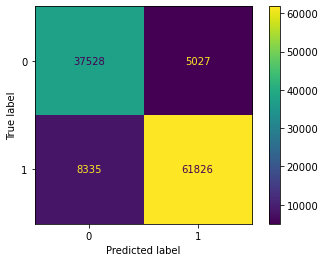



---- Classification report for Training Set -----

              precision    recall  f1-score   support

           0       0.85      0.91      0.88    127663
           1       0.94      0.90      0.92    210484

    accuracy                           0.90    338147
   macro avg       0.89      0.90      0.90    338147
weighted avg       0.91      0.90      0.90    338147



---- Classification report for Test Set -----

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     42555
           1       0.92      0.88      0.90     70161

    accuracy                           0.88    112716
   macro avg       0.87      0.88      0.88    112716
weighted avg       0.88      0.88      0.88    112716



In [25]:
print("-----------------------------------------------")
print("     Logistic Regression Model with TF-IDF     ")
print("-----------------------------------------------\n")
modeling_evaluation(logreg, X_train_tf_idf, X_test_tf_idf)

--------------------------------------------------------
 Linear Support Vector Classification Model with TF-IDF 
--------------------------------------------------------

------ Confusion Matrix ------

[[37301  5254]
 [ 7607 62554]]


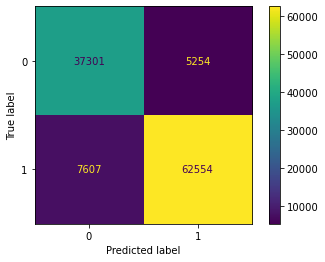



---- Classification report for Training Set -----

              precision    recall  f1-score   support

           0       0.92      0.96      0.94    127663
           1       0.98      0.95      0.96    210484

    accuracy                           0.96    338147
   macro avg       0.95      0.96      0.95    338147
weighted avg       0.96      0.96      0.96    338147



---- Classification report for Test Set -----

              precision    recall  f1-score   support

           0       0.83      0.88      0.85     42555
           1       0.92      0.89      0.91     70161

    accuracy                           0.89    112716
   macro avg       0.88      0.88      0.88    112716
weighted avg       0.89      0.89      0.89    112716



In [26]:
print("--------------------------------------------------------")
print(" Linear Support Vector Classification Model with TF-IDF ")
print("--------------------------------------------------------\n")
modeling_evaluation(svc, X_train_tf_idf, X_test_tf_idf)

#### Result Interpretation
As we can see from the classification report for both the training set and test set, precision, recall, and f1-score are pretty good in both models. However, LinearSVC gives slightly better results than Logistic Regression.

Now, we focus on the minority class (class 0 or 'bad' rating class) and pick this class as a positive class in the confusion matrix result of the LinearSVC model. 

- If we want to predict a review is bad, only if we are very confident, we will use 83% of precision.

- If we want to avoid missing too many cases of bad, we will use 88% of recall.

There is a trade-off between optimizing precision and recall, and it depends on our purpose, as mentioned above. For instance, if our company doesn't want to ignore any bad reviews from customers to improve service quality, we will try to optimize the recall metric.

A similar interpretation could be made if we pick good rating class as a positive class in the confusion matrix.

In another aspect, If we want to use a balanced metric for both precision and recall to compare the performance between two models, we can use F1-score. In this case, Logistic Regression and LinearSVC has the same F1-score for class 0 (Bad) = 85%.


### 5.2. Review Process  <a class="anchor" id="5.2-bullet"></a>
As a result of reviewing the whole process of this project, we developed a good interrelation between steps. However, there are several things we could improve: 
- We could do some more analysis in the Data Understanding phase to get more insights
- In the Data Preparation stage, the normalization and lemmatization phase take a long time to complete. In addition to that, we could look in more detail to remove more unmeaningful words
- In the Modeling phase, although we got the data mining goal, it seems to be like we haven't explored all the valuable insights from the reviews. This should be done in business understanding again to define new business objectives.


### 5.3. Determine next steps  <a class="anchor" id="5.3-bullet"></a>
Due to time limitations, we aren't able to do all that we could in this project. The next steps will be determined based on our business objectives and data mining objectives in the future. In particular, this project could do the followings:
- Tune the hyperparameter, like changing the C value or algorithms in the model to improve the evaluation metrics.
- Use cross-validation and Gridsearch to improve the performance
- Although our dataset is slightly imbalanced, we also can try SMOTE to balance the dataset to test the effect on the model
- Examine other models and use ROC, AUC to evaluate the performance between them
- Build a Neural networks model for text classification to see how well NNs perform on text data.
- ApplyTopic Modeling will be useful for further categorization of new reviews
- Build the pipeline to implement the whole process


#### Now, we completed the phase 04. Modeling and Evaluation.  It is also the last phase in our project.
Go back to the main notebook [01. MainNotebook](CA_TanThienNguyen_C00278719_01_MainNotebook.ipynb)